# 1. Importar paquetes y exploración inicial de datos

In [1]:
# Manejo de  datos
import pandas as pd                          # Manipular DataFrames y DataArrays
import geopandas as gpd                      # Manipular GeoDataFrames y GeoDataArrays
import numpy as np                           # Manipular array y otros algoritmos matematicos
from openpyxl import load_workbook
from scipy import interpolate
import matplotlib.patches as mpatches

# Funciones elementales
from functools import reduce
from glob import glob
import os

# Funciones para SIG
from pyproj import Proj

# Obtener metricas
import ppscore as pps

#Funciones para graficar
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates


output_folder = "Output/P001calidad_aire"
if os.path.isdir(output_folder) == False:
    os.mkdir(output_folder)

In [2]:
def lectura_csv(path):
    variable = path.split("_")[1]
    data = pd.read_csv(path, sep=";", dtype=str).iloc[:, :-1]
    # Definición fecha
    data['Fecha'] = pd.to_datetime('20' + data['FECHA (YYMMDD)'] + ' ' + data['HORA (HHMM)'] + '00', format="%Y%m%d %H%M%S")
    data          = data.drop(['FECHA (YYMMDD)', 'HORA (HHMM)'], axis=1)
    if ("Unnamed: 2" in data.columns) == True:
        data = data.rename({"Unnamed: 2": variable}, axis=1)
    if ('Registros validados' in data.columns) == True:
        data = data.drop(['Registros no validados', 'Registros preliminares'], axis=1)\
            .rename({'Registros validados': variable}, axis=1)
    data[variable] = data[variable].str.replace(',', '.').astype(np.float32)
    return data

def lectura_todoscsv(paths, UTM_N, UTM_E, projection):
    data = reduce(lambda left,right: pd.merge(left,right,on='Fecha', how="outer"), [lectura_csv(path) for path in paths])
    data["lon"], data["lat"] = projection(UTM_E, UTM_N, inverse=True)
    data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(x=data.lon, y=data.lat))
    return data.set_index("Fecha").sort_index()

paths         = sorted(glob('Data/calidad aire/*.csv'))
UTM_N         = 6171746
UTM_E         = 317503
projection    = Proj("EPSG:9155") #SIRGAS-Chile 2016 / UTM zone 19S https://epsg.io/9155
df            = lectura_todoscsv(paths, UTM_N, UTM_E, projection)

In [3]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 123263 entries, 2007-03-31 01:00:00 to 2021-04-21 23:00:00
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   HR         69662 non-null   float32 
 1   MP10Hr     58635 non-null   float32 
 2   MP25Hr     31491 non-null   float32 
 3   OzoneHr    68196 non-null   float32 
 4   Pressure   65194 non-null   float32 
 5   Rad        69660 non-null   float32 
 6   Temp       67481 non-null   float32 
 7   VientoDir  121563 non-null  float32 
 8   VientoVel  122014 non-null  float32 
 9   lon        123263 non-null  float64 
 10  lat        123263 non-null  float64 
 11  geometry   123263 non-null  geometry
dtypes: float32(9), float64(2), geometry(1)
memory usage: 8.0 MB


In [4]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(df.describe().T)

               count    mean     std     min     25%     50%     75%      max
HR         69662.000  63.411  22.688   0.000  45.436  65.093  82.400  105.000
MP10Hr     58635.000  43.580  35.440   1.000  23.000  35.500  52.339  760.000
MP25Hr     31491.000  21.939  26.336   1.000   8.000  14.000  27.000  341.525
OzoneHr    68196.000  14.253  11.439   0.510   5.000  11.781  20.499   69.625
Pressure   65194.000 814.346 204.271   0.000 551.692 975.000 979.000 1072.670
Rad        69660.000 176.566 263.823   0.000   0.000   5.843 297.516 1019.000
Temp       67481.000  14.645   6.866  -2.451   9.600  13.700  19.200   34.700
VientoDir 121563.000 174.152  62.255   0.000 146.000 173.000 219.000  360.000
VientoVel 122014.000   1.745   0.845   0.000   1.100   1.700   2.300    7.800
lon       123263.000 -70.990   0.000 -70.990 -70.990 -70.990 -70.990  -70.990
lat       123263.000 -34.580   0.000 -34.580 -34.580 -34.580 -34.580  -34.580


# 2. Visualización de los datos
## 2.1 Series de Tiempo

In [5]:
def series_de_tiempo(df, variable, nombre_estacion, xlabel, ylabel, output_folder, **kwargs):
    """
    Descripción: Función para graficar series de tiempo con promedio mensual.

    df          (Dataframe):    Conjunto de datos a graficar.
    variable          (str):    Variable en "str" que se desea graficar.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.
    xlabel            (str):    Nombre de eje x del gráfico.
    ylabel            (str):    Nombre de eje y del gráfico.
    **kwargs               :    Variables que no están definidas en la función directamente, pero que una vez que
                                ajuste a sus requerimientos, pueden ser cambiadas. Recordar que si se tiene kwargs debe estar definido cuando se llama la función.

    Ejemplo:
        series_de_tiempo(
            df              = df,
            variable        = "velocidadDir",
            nombre_estacion = "Estación San Fernando",
            xlabel          = "Tiempo [años]",
            ylabel          = "Dirección del viento (°)",
            ylim            = {"bottom": 0, "top": 360},
            major_locator   = {"locator": mdates.YearLocator()},
            major_formatter = {"formatter": mdates.DateFormatter('%Y')}
            )
    """
    # Limpieza de valores NaN.
    df = df[variable].dropna()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    # Crear figura, los valores pueden ser modificados en función de lo que se necesite.
    fig, ax = plt.subplots(
        figsize     = (9,6),
        gridspec_kw = {'left':0.075, 'right':0.975, 'top':0.945, 'bottom':0.085},
        facecolor   ='w',
        edgecolor   ='w')

    # Graficar datos, se recomienda como punto y no lineas.
    ax.plot(
        df,
        ls     = "None",
        ms     = 0.5,
        marker = '.',
        c      = 'blue',
        label  = "Datos",
        alpha  = 1,
        zorder = 4
    )

    # Definición de limites: "x" corresponde al tiempo e "y" corresponde a el valor a graficar.
    ax.set_xlim( df.index.min(), df.index.max() )
    ax.set_ylim( **kwargs["ylim"] )

    # Definición de etiqueta del eje "x" y el eje "y".
    ax.set_xlabel( xlabel, fontsize =  11, fontweight = "normal", labelpad = 2.5)
    ax.set_ylabel( ylabel, fontsize =  11, fontweight = "normal", labelpad = 2.5)

    # Coloca ticks en cada año y el formato de cada uno de los ticks
    ax.xaxis.set_major_locator(**kwargs["major_locator"])
    ax.xaxis.set_major_formatter( **kwargs["major_formatter"] )

    # Definición de tipografía del eje "x", el eje "y" y la grilla.
    ax.grid(True)
    ax.tick_params(
        axis = "both", which = "major", direction = "in", length = 7.5, width = 1, pad = 5,
        grid_color = 'k', grid_linewidth = 0.5, grid_linestyle = "--", grid_alpha = 0.8,
        bottom = True, top = True, left = True, right = True)

    # Definición de legenda
    ax.legend(
        loc = 0, ncol = 2, fontsize = 10, markerscale = 10, facecolor = 'lightgrey', edgecolor = 'k')
    # Definición del titulo del gráfico
    fig.suptitle(
        "Serie de Tiempo de "+ylabel+" "+nombre_estacion,
        size = 11, weight = "normal")
    # Guarda la figura
    fig.savefig(
        plot_folder+"/ST_"+variable+"_"+nombre_estacion.replace(" ","")+".png",
        facecolor = 'w', edgecolor = 'w', dpi = 96)
    # Cierra la figura
    plt.close(fig)
    return

contenedor_de_limites = {
    "HR"         : [0, 100,  "Humedad relativa del aire (%)"],
    "MP10Hr"     : [0, 1000, "Material Particulado MP10 (μg/m3N)"],
    "MP25Hr"     : [0, 350,  "Material Particulado MP2.5 (μg/m3)"],
    "OzoneHr"    : [0, 100,  "Ozono (ppb)"],
    "Rad"        : [0, 1200, "Radiación global (W/m2)"],
    "Temp"       : [-5, 40,  "Temperatura ambiente (°C)"],
    "VientoDir"  : [0, 360,  "Dirección del viento (°)"],
    "VientoVel"  : [0, 8,    "Velocidad del viento (m/s)"],
}

for variable, [vmin, vmax, var_title] in contenedor_de_limites.items():
    series_de_tiempo(
        df              = df,
        variable        = variable,
        nombre_estacion = "Estación San Fernando",
        xlabel          = "Tiempo [años]",
        ylabel          = var_title,
        output_folder   = output_folder,
        ylim            = {"bottom": vmin, "top": vmax},
        major_locator   = {"locator": mdates.YearLocator()},
        major_formatter = {"formatter": mdates.DateFormatter('%Y')}
    )

## 2.2 Ciclos Diarios

In [6]:
def ciclo_diario(df, variable, nombre_estacion, xlabel, ylabel, output_folder, **kwargs):
    """
    Descripción: Función para graficar ciclo diario con promedio horario.

    df          (Dataframe):    Conjunto de datos a graficar.
    variable          (str):    Variable en "str" que se desea graficar.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.
    xlabel            (str):    Nombre de eje x del gráfico.
    ylabel            (str):    Nombre de eje y del gráfico.
    **kwargs               :    Variables que no están definidas en la función directamente, pero que una vez que
                                ajuste a sus requerimientos, pueden ser cambiadas. Recordar que si se tiene kwargs debe estar definido cuando se llama la función.
    Ejemplo:
        ciclo_diario(
        df              = df,
        variable        = "vientoVel",
        nombre_estacion = "Estación San Fernando",
        xlabel          = "Hora Local [horas]",
        ylabel          = "Velocidad del viento (m/s)",
        ylim            = {"bottom": 0, "top": 5},
        )
    """
    #Limpieza de valores NaN.
    df = df[variable].dropna()

    #Agrupar datas por hora.
    df = df.groupby(df.index.hour)

    #Calcular percentil 95, percentil 5 y promedio de los datos.
    df_P95 = df.apply(lambda x: np.percentile(x, 95))
    df_P05 = df.apply(lambda x: np.percentile(x, 5))
    df_promedio = df.mean()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    #Crear figura, los valores pueden ser modificados en función de lo que se necesite.
    fig, ax = plt.subplots(
        figsize     = (9,6),
        gridspec_kw = {'left':0.075, 'right':0.975, 'top':0.945, 'bottom':0.085},
        facecolor   ='w',
        edgecolor   ='w')

    #Graficar promedio de los datos.
    ax.plot(df_promedio, ls = "-", lw = 1.5, c = "blue", label = "Promedio", zorder = 2)
    ax.plot(df_P05, ls = "-", lw = 1.0, c = "k", label = "__no_legend__", zorder = 2)
    ax.plot(df_P95, ls = "-", lw = 1.0, c = "k", label = "__no_legend__", zorder = 2)

    #Graficar el 90% de los datos.
    ax.fill_between(
        x = df_P05.index, y1 = df_P05, y2 = df_P95, alpha = 0.3, color = 'blue', zorder = 2, label = "90% de datos")

    #Definición de limites: "x" corresponde al tiempo e "y" corresponde a el valor a graficar.
    ax.set_xlim(df_P95.index.min(), df_P95.index.max())
    ax.set_ylim(**kwargs["ylim"])

    #Definición de etiqueta del eje "x" y el eje "y".
    ax.set_xlabel(xlabel, fontsize = 11, fontweight = "normal", labelpad = 2.5)
    ax.set_ylabel(ylabel, fontsize = 11, fontweight = "normal", labelpad = 2.5)

    # Definición de tipografía del eje "x", el eje "y" y la grilla.
    ax.grid(True)
    ax.set(xticks = df_promedio.index)
    ax.tick_params(
        axis = "both", which = "major", direction = "in", length = 7.5, width = 1, pad = 5,
        grid_color = 'k', grid_linewidth = 0.75, grid_linestyle = "--", grid_alpha = 0.8,
        bottom = True, top = True, left = True, right = True)

    # Definición de legenda
    ax.legend(
        loc = 0, ncol = 2, fontsize = 10, markerscale = 10, facecolor = 'lightgrey', edgecolor = 'k')
    # Definición del titulo del gráfico
    fig.suptitle(
        "Ciclo Diario de "+ylabel+" "+nombre_estacion,
        size = 11, weight = "normal")
    # Guarda la figura
    fig.savefig(
        plot_folder+"/CD_"+variable+"_"+nombre_estacion.replace(" ","")+".png",
        facecolor = 'w', edgecolor = 'w', dpi = 96)
    # Cierra la figura
    plt.close(fig)
    return

contenedor_de_limites = {
    "HR"         : [0, 100, "Humedad relativa del aire (%)"],
    "MP10Hr"     : [0, 200, "Material Particulado MP10 (μg/m3N)"],
    "MP25Hr"     : [0, 120,  "Material Particulado MP2.5 (μg/m3)"],
    "OzoneHr"    : [0, 60,  "Ozono (ppb)"],
    "Rad"        : [0, 1000, "Radiación global (W/m2)"],
    "Temp"       : [0, 40,  "Temperatura ambiente (°C)"],
    "VientoVel"  : [0, 5,   "Velocidad del viento (m/s)"],
}

for variable, [vmin, vmax, var_title] in contenedor_de_limites.items():
    ciclo_diario(
        df              = df,
        variable        = variable,
        nombre_estacion = "Estación San Fernando",
        xlabel          = "Hora Local [horas]",
        ylabel          = var_title,
        ylim            = {"bottom": vmin, "top": vmax},
        output_folder   = output_folder
    )

In [7]:
def ciclo_diario_direccion(df, variable, nombre_estacion, vmin, vmax, output_folder, **kwargs):
    """
    Descripción: Función para graficar series de tiempo con promedio mensual.

    df          (Dataframe):    Conjunto de datos a graficar.
    variable          (str):    Variable en "str" que se desea graficar.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.
    vmin              (int):    Probabilidad mínima.
    vmax              (int):    Probabilidad máxima.
    **kwargs               :    Variables que no están definidas en la función directamente, pero que una vez que
                                ajuste a sus requerimientos, pueden ser cambiadas. Recordar que si se tiene kwargs debe estar definido cuando se llama la función.
    Ejemplo:
    ciclo_diario_direccion(
        df              = df,
        variable        = "vientoDir",
        nombre_estacion = "Estación San Fernando",
        vmin            = 0,
        vmax            = 30
        )
    """
    #Limpieza de valores NaN.
    df = df.filter([variable]).dropna()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    #Creación de diccionario para definir la dirección del viento, en este caso se considera que la dirección esta en el rango de 0° a 360°.
    step        = 15
    bins        = np.arange(step/2, 360, step)
    directions  = {n: ndir for n, ndir in enumerate(np.arange(0, 360+step, step))}

    # clasificación de dirección en número de 1 al 16
    df["nombre_viento"] = np.digitize(x = df[variable], bins=bins)
    df["nombre_viento"] = df["nombre_viento"].map(directions)

    # Se agrega la columna hora para agilizar tabla pivote
    df['HORA'] = df.index.hour

    #función para determinar frecuencia relativa de una SerieFrame
    freq_relativa = lambda x: 100*x/x.sum()

    # Tabla pivote con índice la clasificación que se le da al viento y en las columnas la hora, se considera usar la función count para contar los valores que cumplen esa dirección a esa hora.
    pivot_table = pd.pivot_table(data=df, values = variable, index="nombre_viento",columns="HORA", aggfunc="count")

    #Determina la frecuencia relativa por cada hora
    pivot_table = pivot_table.apply(freq_relativa, axis=0)
    name_file = data_folder+"/CD_"+variable+"_"+nombre_estacion.replace(" ","")+".xlsx"
    if os.path.isfile(name_file)==True:
        ExcelWorkbook = load_workbook(name_file)
        writer = pd.ExcelWriter(name_file, engine = 'openpyxl')
        writer.book = ExcelWorkbook
        pivot_table.to_excel(writer, sheet_name=variable)
        writer.save()
        writer.close()
    else:
        pivot_table.to_excel(name_file, sheet_name=variable)

    #Crear figura, los valores pueden ser modificados en función de lo que se necesite.
    fig, (ax, cbar_ax) = plt.subplots(
        ncols       = 2,
        figsize     = (9,6),
        gridspec_kw = {'wspace':0.025, 'hspace':0.25, 'left':0.075, 'right':0.925, 'top':0.950, 'bottom':0.1, "width_ratios": [.9, .025]},
        facecolor   ='lightgrey',
        edgecolor   ='w')

    #Graficar promedio de los datos.
    cf = ax.imshow(
        pivot_table, **{"cmap": "jet", "origin": "lower", "vmin": vmin, "vmax": vmax, "zorder": 0, "aspect":"auto"})
    plt.colorbar(cf, cax= cbar_ax, ticks = np.arange(vmin, vmax + 5, 5))

    #Definición de etiqueta del eje "x" y el eje "y".
    ax.set_xlabel("Hora Local [horas]", fontsize = 11, fontweight = "normal", labelpad = 2.5)
    ax.set_ylabel("Dirección del Viento (°)", fontsize = 11, fontweight = "normal", labelpad = 2.5)

    # #Definición de números o tipografía del eje "x" o el eje "ylabelfw
    ax.set(xticks = pivot_table.columns,
           yticks = np.arange(0, len(pivot_table.index), 2),
           yticklabels = pivot_table.index[::2].astype(np.int32))
    ax.tick_params(
        axis = "both", which = "major", direction = "in", length = 5, width = 1, pad = 5,
        grid_color = 'k', grid_linewidth = 0.75, grid_linestyle = "--", grid_alpha = 0.8,
        bottom = True, top = True, left = True, right = True, labelsize = 10)
    # #Definición de grilla, legenda y extras.
    ax.set_title(
        "Histograma del Ciclo Diario de la Dirección del Viento "+nombre_estacion,
        **{"size": 12, "weight": "bold", "pad": 5})
    cbar_ax.set_ylabel("Frecuencia (%)", fontsize = 11, labelpad = 2.5, fontweight="normal")

    # Guardar figura
    fig.savefig(
        plot_folder+"/CD_"+variable+"_"+nombre_estacion.replace(" ","")+".png",
        facecolor = 'w', edgecolor = 'w', dpi = 96)
    # Cierra la figura
    plt.close(fig)
    return

ciclo_diario_direccion(
    df              = df,
    variable        = "VientoDir",
    nombre_estacion = "Estación San Fernando",
    vmin            = 0,
    vmax            = 30,
    output_folder   = output_folder
)

## 2.3 Ciclos estacionales

In [8]:
def ciclo_estacional_viento(df, velocidad, direccion, nombre_estacion, vmin, vmax, step, output_folder, **kwargs):
    """
    Descripción: Función para graficar ciclo estacional del  viento.

    df          (Dataframe):    Conjunto de datos a graficar.
    velocidad         (str):    Variable que corresponde a la velocidad del viento.
    dirección         (str):    Variable que corresponde a la dirección del viento.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.
    vmin              (int):    Valor mínimo.
    vmax              (int):    Valor máximo.
    step              (int):    Valor del paso a paso.
    **kwargs               :    Variables que no están definidas en la función directamente, pero que una vez que
                                ajuste a sus requerimientos, pueden ser cambiadas. Recordar que si se tiene kwargs debe estar definido cuando se llama la función.
    """
    #Limpieza de valores NaN.
    df = df.filter([velocidad, direccion]).dropna()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    # Se agrega la columna hora y mes para tabla pivote
    df['HORA'] = df.index.hour
    df['MES']  = df.index.month
    df['udir'] = df[velocidad]*np.sin(df[direccion] * np.pi/180)# + np.pi)
    df['vdir'] = df[velocidad]*np.cos(df[direccion] * np.pi/180)# + np.pi)

    # Tabla pivote con índice el mes y columna la hora, se considera usar la función mean para mostrar el promedio de los datos.
    pivote_viento = pd.pivot_table(data=df, values=velocidad, index="MES", columns="HORA", aggfunc="mean")
    pivote_udir   = pd.pivot_table(data=df, values="udir", index="MES", columns="HORA", aggfunc="mean")
    pivote_vdir   = pd.pivot_table(data=df, values="vdir", index="MES", columns="HORA", aggfunc="mean")

    name_file = data_folder+"/CE_"+nombre_estacion.replace(" ","")+".xlsx"
    if os.path.isfile(name_file)==True:
        ExcelWorkbook = load_workbook(name_file)
        writer = pd.ExcelWriter(name_file, engine = 'openpyxl')
        writer.book = ExcelWorkbook
        pivote_viento.to_excel(writer, sheet_name="viento")
        writer.save()
        writer.close()
    else:
        pivote_viento.to_excel(name_file, sheet_name="viento")


    #Interpolación pivote
    n = 5
    x = np.arange(pivote_viento.columns.min() - 1 - 1/n, pivote_viento.columns.max() + 1, 1/n )
    y = np.arange(pivote_viento.index.min()   - 1 - 1/n, pivote_viento.index.max()   + 1, 1/n )
    f_viento = interpolate.interp2d(pivote_viento.columns, pivote_viento.index, pivote_viento.values, kind='linear')
    f_udir   = interpolate.interp2d(pivote_udir.columns, pivote_udir.index, pivote_udir.values, kind='linear')
    f_vdir   = interpolate.interp2d(pivote_vdir.columns, pivote_vdir.index, pivote_vdir.values, kind='linear')
    z_viento = f_viento(x, y)
    u        = f_udir(x, y)
    v        = f_vdir(x, y)

    #Crear figura, los valores pueden ser modificados en función de lo que se necesite.
    fig, (ax, cbar_ax) = plt.subplots(
        ncols       = 2,
        figsize     = (9,6),
        gridspec_kw = {'wspace':0.025, 'hspace':0.25, 'left':0.075, 'right':0.925, 'top':0.950, 'bottom':0.1, "width_ratios": [.9, .025]},
        facecolor   ='lightgrey',
        edgecolor   ='w')

    # Grafico de contornos, correspondiente a la velocidad del viento
    cf = ax.contourf(x, y, z_viento, **{"levels": np.arange(vmin, vmax + step, step), "cmap": 'jet'})
    ax.contour(x, y, z_viento, **{"levels": np.arange(vmin, vmax + step, step), "colors": "black", "linewidths": 0.15})

    # Grafico que contiene las flechas que representan la dirección del viento
    ax.quiver(x[1::n], y[1::n], u[1::n, 1::n], v[1::n, 1::n], scale_units='xy', scale=5, units="xy", width=0.025, headwidth=3., headlength=4.)

    # Grafico que corresponde a la barra de colores
    plt.colorbar(cf, cax= cbar_ax, **{"ticks":  np.arange(vmin, vmax + step*10, step*10)})

    # #Definición de etiqueta del eje "x", el eje "y" y colorvar
    ax.set_xlabel("Hora", **{"fontsize": 11, "fontweight": "normal", "labelpad": 2.5})
    ax.set_ylabel("Mes", **{"fontsize": 11, "fontweight": "normal", "labelpad": 2.5})
    cbar_ax.set_ylabel("Velocidad del viento (m/s)", **{"fontsize": 11, "fontweight": "normal", "labelpad": 5})

    # #Definición de números o tipografía del eje "x", eje "y" y colorbar
    ax.set(
        xticks = pivote_viento.columns,
        yticks = pivote_viento.index,
        xticklabels = pivote_viento.columns,
        yticklabels = ["E", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    )
    ax.tick_params(axis="both", **{"labelsize": 10, "length": 5, "direction": "in", "width": 1.25, "pad": 5})
    cbar_ax.tick_params(labelsize = 10)

    # Definición de limites
    ax.set_xlim(pivote_viento.columns.min() - 5/(2*n), pivote_viento.columns.max() + 5/(2*n))
    ax.set_ylim(pivote_viento.index.min()   - 5/(2*n), pivote_viento.index.max()   + 5/(2*n))

    # Definición de titulo
    ax.set_title("Ciclo Estacional del viento "+nombre_estacion, **{"size": 12, "weight": "normal", "pad": 5})

    # Guarda la figura
    fig.savefig(
        plot_folder+"/CE_Viento_"+nombre_estacion.replace(" ","")+".png",
        facecolor = 'w', edgecolor = 'w', dpi = 96)

    # Cierra la figura
    plt.close(fig)
    return

ciclo_estacional_viento(
    df              = df,
    velocidad       = "VientoVel",
    direccion       = "VientoDir",
    nombre_estacion = "Estación San Fernando",
    vmin            = 0,
    vmax            = 3,
    step            = 0.05,
    output_folder   = output_folder
)

In [9]:
def ciclo_estacional(df, variable, nombre_estacion, vmin, vmax, step, clabel, unidad, output_folder, **kwargs):
    """
    Descripción: Función para graficar ciclo estacional del viento.

    df          (Dataframe):    Conjunto de datos a graficar.
    variable          (str):    Variable en "str" que se desea graficar.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.
    vmin              (int):    Valor mínimo.
    vmax              (int):    Valor máximo.
    step              (int):    Valor del paso a paso.
    clabel            (str):    Nombre completo de variable.
    unidad            (str):    Unidad correspondiente a la variable.

    Ejemplo:
    ciclo_estacional(
        df              = df,
        variable        = "HR",,
        nombre_estacion = "Estación San Fernando",
        vmin            = 0,
        vmax            = 100,
        step            = 2,
        clabel          = "Humedad Relativa del Aire",
        unidad          = "(%)",
        )
    """
    #Limpieza de valores NaN.
    df = df.filter([variable]).dropna()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    # Se agrega la columna hora y mes para tabla pivote
    df['HORA'] = df.index.hour
    df['MES']  = df.index.month

    # Tabla pivote con índice el mes y columna la hora, se considera usar la función mean para mostrar el promedio de los datos.
    pivote_var  = pd.pivot_table(data=df, values=variable, index="MES", columns="HORA", aggfunc="mean")

    # Guardar pivote en archivo excel
    name_file = data_folder+"/CE_"+nombre_estacion.replace(" ","")+".xlsx"
    if os.path.isfile(name_file)==True:
        ExcelWorkbook = load_workbook(name_file)
        writer = pd.ExcelWriter(name_file, engine = 'openpyxl')
        writer.book = ExcelWorkbook
        pivote_var.to_excel(writer, sheet_name=variable)
        writer.save()
        writer.close()
    else:
        pivote_var.to_excel(name_file, sheet_name=variable)



    #Interpolación pivote
    n = 5
    x = np.arange(pivote_var.columns.min() - 1 - 1/n, pivote_var.columns.max() + 1, 1/n )
    y = np.arange(pivote_var.index.min()   - 1 - 1/n, pivote_var.index.max()   + 1, 1/n )
    f_var  = interpolate.interp2d(pivote_var.columns , pivote_var.index , pivote_var.values , kind='linear')
    z_var  = f_var(x, y)

    #Crear figura, los valores pueden ser modificados en función de lo que se necesite.
    fig, (ax, cbar_ax) = plt.subplots(
        ncols       = 2,
        figsize     = (9,6),
        gridspec_kw = {'wspace':0.025, 'hspace':0.25, 'left':0.075, 'right':0.925, 'top':0.950, 'bottom':0.1, "width_ratios": [.9, .025]},
        facecolor   ='lightgrey',
        edgecolor   ='w')

    # Grafico de contornos, correspondiente a la velocidad del viento
    cf = ax.contourf(
        x, y, z_var, **{"levels": np.arange(vmin, vmax + step, step), "cmap": 'jet'})
    ax.contour(
        x, y, z_var, **{"levels": np.arange(vmin, vmax + step, step), "colors": "black", "linewidths": 0.1})

    # Grafico que corresponde a la barra de colores
    plt.colorbar(cf, cax= cbar_ax, **{"ticks":  np.arange(vmin, vmax + step, step*5)})

    # Definición de etiqueta del eje "x" y el eje "y".
    ax.set_xlabel("Hora", **{"fontsize": 11, "fontweight": "normal", "labelpad": 2.5})
    ax.set_ylabel("Mes", **{"fontsize": 11, "fontweight": "normal", "labelpad": 2.5})
    cbar_ax.set_ylabel(clabel+" "+unidad, **{"fontsize": 11, "fontweight": "normal", "labelpad": 2.5})

    # Definición de números o tipografía del eje "x", eje "y" y "colorbar"
    ax.set(
        xticks = pivote_var.columns,
        yticks = pivote_var.index,
        xticklabels = pivote_var.columns,
        yticklabels = ["E", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    )
    ax.tick_params(axis="both", **{"labelsize": 10, "length": 5, "direction": "in", "width": 1.25, "pad": 5})
    cbar_ax.tick_params(labelsize = 10)

    # Definición de limites
    ax.set_xlim(pivote_var.columns.min() - 5/(2*n), pivote_var.columns.max() + 5/(2*n))
    ax.set_ylim(pivote_var.index.min()   - 5/(2*n), pivote_var.index.max()   + 5/(2*n))

    # Definición de titulo
    ax.set_title("Ciclo Estacional "+clabel+" "+nombre_estacion, **{"size": 12, "weight": "normal", "pad": 5})

    # Guarda la figura
    fig.savefig(
        plot_folder+"/CE_"+variable+"_"+nombre_estacion.replace(" ","")+".png",
        facecolor = 'w', edgecolor = 'w', dpi = 96)

    # Cierra la figura
    plt.close(fig)
    return

contenedor_de_limites = {
    "HR"       : [0, 100,  2.0, "Humedad relativa del aire",  "(%)"],
    "MP10Hr"   : [0, 150,  5.0, "Material Particulado MP10",  "(μg/m3N)"],
    "MP25Hr"   : [0, 100,  5.0, "Material Particulado MP2.5", "(μg/m3)"],
    "OzoneHr"  : [0, 50,   1.0, "Ozono", "(ppb)"],
    "Rad"      : [0, 1000,  50, "Radiación global", "(W/m2)"],
    "Temp"     : [0, 30,   1.0, "Temperatura ambiente", "(°C)"],
}
for variable, [vmin, vmax, step, var_title, unit] in contenedor_de_limites.items():
    ciclo_estacional(
        df              = df,
        variable        = variable,
        nombre_estacion = "Estación San Fernando",
        vmin            = vmin,
        vmax            = vmax,
        step            = step,
        clabel          = var_title,
        unidad          = unit,
        output_folder   = output_folder
    )

## 2.4 Rosa de los vientos¶

In [10]:
def clasificando_viento(df, nrosa, var_vientos, var_direccion, nombre_estacion, data_folder):
    #clasificación del viento según su velocidad
    escala = {
        0  : 'Calma',
        1  : '0,50 - 2,10',
        2  : '2,10 - 3,60',
        3  : '3,60 - 5,70',
        4  : '5,70 - 8,80',
        5  : '8,80 - 11,10',
        6  : '>= 11,10',}
    bins_vel = np.array([0.5, 2.10, 3.60, 5.70, 8.80, 11.10])
    df['clase_velocidad'] = np.digitize(x = df[var_vientos], bins=bins_vel)

    # Clasificación viento según la dirección
    if nrosa == 8:
        step            = 360/nrosa
        name_directions = np.array('N NE E SE S SW W NW N'.split())
        bins            = np.arange(step/2, 360 + step, step)
        print(bins)
    elif nrosa == 16:
        step            = 360/nrosa
        name_directions = np.array('N NNE NE ENE E ESE SE SSE S SSW SW WSW W WNW NW NNW N'.split())
        bins            = np.arange(step/2, 360 + step, step)

    directions = {n: dir for n, dir in enumerate(name_directions)}
    df["Nclase_direccion"] = np.digitize(x = df[var_direccion], bins=bins)
    df["clase_direccion"]  = df["Nclase_direccion"].map(directions)

    # Determinación de la tabla pivote
    pivote = pd.pivot_table(
        df,
        values     = var_vientos,
        index      = "clase_velocidad",
        columns    = "clase_direccion",
        aggfunc    = "count",
        fill_value = 0)[name_directions[:-1]]
    pivote.index   = pivote.index.map(escala)
    pivote.to_excel(data_folder+"/rosadelosviento_"+nombre_estacion.replace(" ","")+".xlsx")
    calmas = pivote.iloc[0].sum().sum()*100/len(df)
    pivote = pivote[1:]
    pivote = pivote*100/pivote.sum().sum()
    return pivote, calmas, name_directions

def rosa_vientos(df, var_vientos, var_direccion, nrosa, nombre_estacion, output_folder, **kwargs):
    """
    Descripción: Función para graficar ciclo diario de una variable.

    df          (Dataframe):    Conjunto de datos a graficar.
    var_vientos       (str):    Variable que representa a los vientos.
    var_direccion     (str):    Variable que representa a los direccion.
    nrosa             (int):    Número que corresponde a una rosa de 8 o 16 direcciones.
    nombre_estacion   (str):    Nombre de la estación de monitoreo.

    Ejemplo:
    rosa_vientos(
        df              = df,
        var_vientos     = "vientoVel",
        var_direccion   = "vientoDir",
        nrose           = 16,
        nombre_estacion = "Estación San Fernando",
        )
    """

    df = df.filter([var_vientos, var_direccion]).dropna()

    # Carpeta para guardar archivos
    plot_folder = output_folder+"/Plot"
    data_folder = output_folder+"/Data"

    if os.path.isdir(plot_folder) == False:
        os.mkdir(plot_folder)
    if os.path.isdir(data_folder) == False:
        os.mkdir(data_folder)

    pivote, calmas, name_directions = clasificando_viento(df, nrosa, var_vientos, var_direccion, nombre_estacion, data_folder)


    # Define figura
    fig=plt.figure(
        figsize=(10,8),
        facecolor = 'lightgrey',
        edgecolor = 'w')

    # definición de la rosa de los viento
    rect      = [0, 0.05, 0.85, 0.85]
    ax        = plt.axes(rect, projection='polar')
    btt       = 0
    direccion = np.linspace(0, 2*np.pi, nrosa+1)
    w         = 2*np.pi/nrosa

    # definición de parámetros polares
    ax.set(**{
        "theta_zero_location": "N",
        "theta_direction": -1,
        "rorigin": -1,
        "rlim": (0,25),
        "rlabel_position": 90,
        "rticks": np.arange(0,25,5)})

    ax.set_thetagrids(direccion*(180/np.pi), name_directions, fontsize = 9)

    # Rosa de los vientos
    for n in range(len(pivote)):
        N = np.array(pivote.iloc[n].tolist())
        ax.bar(
            x = direccion[:nrosa],
            height = N,
            width  = w,
            bottom = btt,
            label = pivote.index[n],
            **{
                "linewidth": 0.25,
                "edgecolor": 'k',
                "zorder": 5})
        btt = btt + N

    # Definición de legenda
    rxz=(0.325, 0.45, 1, 0.15)
    extraString = '{0:5} {1:.2f}%'.format('Calmas:', calmas)
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=extraString))
    ax.legend(handles=handles, bbox_to_anchor=rxz, **{
        "loc": 0,
        "facecolor": 'w',
        "edgecolor": 'k',
        "title": "Velocidad (m/s)",
        "fontsize": 10,
        "title_fontsize": 10})

    # Definición de titulo
    fig.suptitle("Rosa del viento "+nombre_estacion, **{"size": 14, "weight": "bold"})

    # guardar figura
    fig.savefig(**{"fname": plot_folder+"/rosadelosviento_"+nombre_estacion.replace(" ","")+".png",
                   "facecolor": 'lightgrey', "edgecolor": 'k', "dpi": 96})

    # Cierre figura
    plt.close(fig)
    return

rosa_vientos(
    df              = df,
    var_vientos     = "VientoVel",
    var_direccion   = "VientoDir",
    nrosa           = 16,
    nombre_estacion = "Estación San Fernando",
    output_folder   = output_folder
)

# 3. Machine Learning model

# 3.1 EDA

In [25]:
target_columns   = ["MP10Hr", "MP25Hr", "OzoneHr"]
features_columns = df.loc[:, ~df.columns.isin(target_columns + ["lon", "lat", "geometry"])].columns.to_list()

In [26]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print("Targets:\n",df[target_columns].describe().T, "\nFeatures:\n", df[features_columns].describe().T)

Targets:
             count   mean    std   min    25%    50%    75%     max
MP10Hr  58635.000 43.580 35.440 1.000 23.000 35.500 52.339 760.000
MP25Hr  31491.000 21.939 26.336 1.000  8.000 14.000 27.000 341.525
OzoneHr 68196.000 14.253 11.439 0.510  5.000 11.781 20.499  69.625 
Features:
                count    mean     std    min     25%     50%     75%      max
HR         69662.000  63.411  22.688  0.000  45.436  65.093  82.400  105.000
Pressure   65194.000 814.346 204.271  0.000 551.692 975.000 979.000 1072.670
Rad        69660.000 176.566 263.823  0.000   0.000   5.843 297.516 1019.000
Temp       67481.000  14.645   6.866 -2.451   9.600  13.700  19.200   34.700
VientoDir 121563.000 174.152  62.255  0.000 146.000 173.000 219.000  360.000
VientoVel 122014.000   1.745   0.845  0.000   1.100   1.700   2.300    7.800


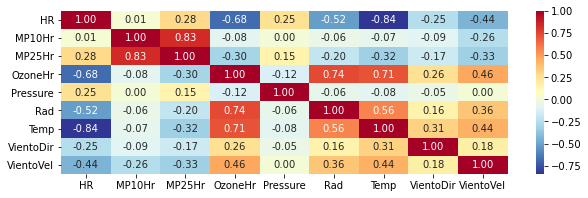

In [36]:
corr_matrix = df.drop(["lat","lon","geometry"], axis = 1).corr()
fig = plt.figure(figsize=(10, len(target_columns)))
_ = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdYlBu_r")

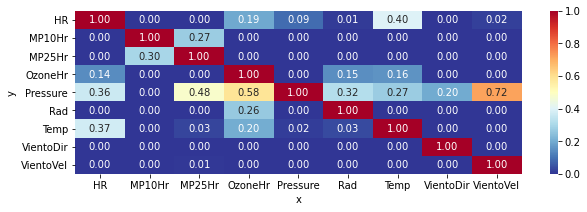

In [40]:
pps_matrix = pps.matrix(df.drop(["lat","lon","geometry"], axis = 1), cross_validation=10)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig = plt.figure(figsize=(10, len(target_columns)))
_ = sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="RdYlBu_r", annot=True, fmt=".2f")

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler_df = pd.DataFrame(MinMaxScaler().fit_transform(df.drop(["lat","lon","geometry"], axis = 1)), columns = df.loc[:, ~df.columns.isin(["lat","lon","geometry"])].columns)
scaler_df.index = df.index
scaler_df.tail(10)

,HR,MP10Hr,MP25Hr,OzoneHr,Pressure,Rad,Temp,VientoDir,VientoVel
Fecha,,,,,,,,,
2021-04-21 14:00:00,0.441357,NaN,NaN,NaN,0.505028,0.167599,0.556023,0.869431,0.489204
2021-04-21 15:00:00,0.445952,NaN,NaN,NaN,0.504884,0.157132,0.558222,0.832328,0.641981
2021-04-21 16:00:00,0.489286,NaN,NaN,NaN,0.505249,0.173683,0.549048,0.843569,0.656099
2021-04-21 17:00:00,0.522492,NaN,NaN,NaN,0.505805,0.079838,0.537383,0.849556,0.515164
2021-04-21 18:00:00,0.522405,NaN,NaN,NaN,0.506053,0.052206,0.527717,0.164881,0.127316
2021-04-21 19:00:00,0.576008,NaN,NaN,NaN,0.509329,0.002635,0.493486,0.526311,0.051687
2021-04-21 20:00:00,0.658802,NaN,NaN,NaN,0.521572,0.000124,0.457552,0.445281,0.182400
2021-04-21 21:00:00,0.735969,NaN,NaN,NaN,0.543317,0.000124,0.421079,0.475950,0.158235
2021-04-21 22:00:00,0.761834,NaN,NaN,NaN,0.555467,0.000158,0.400643,0.578406,0.119781


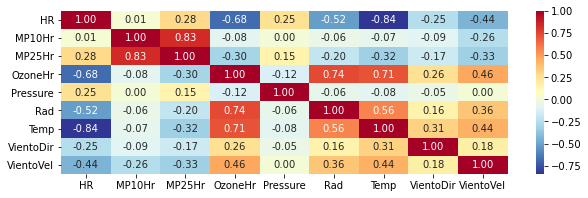

In [39]:
corr_matrix = scaler_df.corr()
fig = plt.figure(figsize=(10, len(target_columns)))
_ = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdYlBu_r")

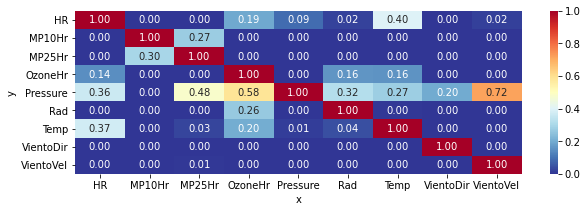

In [41]:
pps_matrix = pps.matrix(scaler_df, cross_validation=10)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig = plt.figure(figsize=(10, len(target_columns)))
_ = sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="RdYlBu_r", annot=True, fmt=".2f")